# Locate FSGP Data

## Objective

We want to use the velocity and lap time data from FSGP 2024 to estimate Brightside's position at every point in time.

## Creating Client

In [6]:
from data_tools.collections.time_series import TimeSeries
from data_tools.query.influxdb_query import DBClient
# from data_tools.query.postgresql_query import PostgresClient
from datetime import datetime, timezone

import numpy as np
import matplotlib.pyplot as plt

client = DBClient()
#client = PostgresClient("can_log_prod", "100.120.36.75", "admin", "new_password")

# DAY 3 LAPS 29-39 have nothing, 40-41 are good

Creating client with API Token: s4Z9_S6_O09kDzYn1KZcs7LVoCA2cVK9_ObY44vR4xMh-wYLSWBkypS0S0ZHQgBvEV2A5LgvQ1IKr8byHes2LA==
Creating client with Org: 8a0b66d77a331e96


## Functions Used

### Original - Before Optimizing

In [7]:
from scipy import integrate as intg

def plot_vehicle_velocity(vel: TimeSeries, test_lap: int):
    plt.plot(vel)
    plt.title(f"Vehicle velocity in lap {test_lap}")
    plt.xlabel("Time [s]")
    plt.ylabel("Speed [ms^-1]")
    plt.show()

def distance_covered(vel: TimeSeries, expected: int = 3.2, save = False):
    dist_m = intg.simpson(vel) # integrate to find distance in m
    distance_mi = dist_m/(1609.344) # convert to miles
    if save:
        return distance_mi
    else:
        print(f"Distance is {distance_mi:.2f} mi. Expected is 3.2 mi.")
        print(f"Difference with expected is {distance_mi-3.2:.4f} mi")

def distance_covered_lap(lap_num: int, save = False):
    start = day.get_start_utc(lap_num)
    stop = day.get_finish_utc(lap_num)
    start_time = datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
    end_time = datetime.strptime(stop, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
    vel: TimeSeries = client.query_time_series(start_time, end_time, "VehicleVelocity", granularity = 1,  units="m/s")
    dist_m = intg.simpson(vel)
    distance_mi = dist_m/1609.344
    if save:
        return dist_m
    else:
        print(f"Distance is {dist_m:.2f} mi. Expected is 3.2 mi.")

def distance_so_far(start: str, stop: str, save = False):
    start_time = datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
    end_time = datetime.strptime(stop, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
    vel: TimeSeries = client.query_time_series(start_time, end_time, "VehicleVelocity", granularity = 1,  units="m/s")
    dist_m = intg.simpson(vel)
    total_track_length = 5033.62413471853 # m
    if save:
        return dist_m, total_track_length
    else:
        print(f"Distance is {dist_m:.2f} m. Total is {total_track_length:.2f} m.")
    
# This assumes start and stop time stamps are in the same lap
def return_coords(start: str, stop: str, lap: int):
    distance = distance_so_far(start, stop, save = True)[0]
    total_lap_distance = distance_covered_lap(lap, save = True)
    total_track_length = 5033.62413471853
    index = gis._python_calculate_closest_gis_indices(np.array([(distance / total_lap_distance) * total_track_length]), gis.get_path_distances())
    return route_data.get("path")[index[0]]

### New - After Optimizing

In [8]:
from scipy import integrate as intg
import numpy as np
import matplotlib.pyplot as plt

# Calculates the distance in a specified lap number
def distance_covered_lap(lap_num: int):
    start = day.get_start_utc(lap_num)
    stop = day.get_finish_utc(lap_num)
    start_time = datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
    end_time = datetime.strptime(stop, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
    vel: TimeSeries = client.query_time_series(start_time, end_time, "VehicleVelocity", granularity = 1,  units="m/s")
    dist_m = intg.simpson(vel) # distance in meters
    return dist_m

# Once you already have a lap number and a velocity array, it calculates the distance you have covered
def distance_so_far(start: datetime, stop: datetime, vel_lap: TimeSeries):
    difference = int(stop.timestamp() - start.timestamp())
    vel = vel_lap[: difference]
    dist_m = intg.simpson(vel)
    return dist_m
    
# This assumes start and stop time stamps are in the same lap
def return_coords(start: datetime, stop: datetime, lap: int):
    distance = distance_so_far(start, stop, vel)
    total_lap_distance = distance_covered_lap(lap, save = True)
    total_track_length = 5033.62413471853
    index = gis._python_calculate_closest_gis_indices(np.array([(distance / total_lap_distance) * total_track_length]), gis.get_path_distances())
    return route_data.get("path")[index[0]]

## Lap Time Information

In [9]:
from data_tools.influxdb.fsgp_2024_laps import FSGPDayLaps

day_num = 3

day = FSGPDayLaps(day_num)

print(f"The number of laps on day {day_num} was {day.get_lap_count()}.")

The number of laps on day 3 was 49.


### Test Lap

In [10]:
# Times are in UTC

test_lap = 44

print(f"Start time for lap {test_lap} is {day.get_start_utc(test_lap)}")
print(f"End time for lap {test_lap} is {day.get_finish_utc(test_lap)}")
print(f"Lap time for lap {test_lap} is {day.get_time(test_lap)}")
print(f"Lap time for lap {test_lap} is {day.get_time_minutes(test_lap)}")

Start time for lap 44 is 2024-07-18T20:27:46Z
End time for lap 44 is 2024-07-18T20:41:49Z
Lap time for lap 44 is 00:14:03
Lap time for lap 44 is 14.05


## Plan Moving Forward

Now I know how to actually get the velocity of the car during a particular lap. In order to locate the car, I have a couple ideas:

- Given a time stamp, determine which lap that time stamp is on
  - After we know what lap we are on, use the velocity data to estimate the vehicle's position relative to the track (can just integrate the velocity vs time plot from lap start time all the way to the time stamp I selected)
  - Would need to get more information on the track. Specifically, how long it is and potentially what shape it has

## Track Information

- Length = 3.2 mi = 5149.9008 m
- Google Earth says Length = 5035.97 m = 3.1292 mi
- **Can use files in Google Earth Folder to find exact coordinates of the track**
- **From the Track Coordinates that we have, we assume the lap length is 5033.62413471853 m = 3.128 mi**

## Aside - Testing with Random Numbers

We are testing integration with a randomly generated data set because InfluxDB was down

In [11]:
# Generating fake data

"""from numpy import random


mean_velocity = 10  # Average velocity
std_deviation = 2   # Controls the spread (smoothness of fluctuations)
num_samples = 500   # Number of velocity data points

# Generate velocities with a normal distribution
velocity = np.random.normal(mean_velocity, std_deviation, num_samples)

# Clipping the values to prevent negative velocities
velocity = np.clip(velocity, 0, None)

times = np.array(range(500))

plt.plot(times, velocity)
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.show()"""

'from numpy import random\n\n\nmean_velocity = 10  # Average velocity\nstd_deviation = 2   # Controls the spread (smoothness of fluctuations)\nnum_samples = 500   # Number of velocity data points\n\n# Generate velocities with a normal distribution\nvelocity = np.random.normal(mean_velocity, std_deviation, num_samples)\n\n# Clipping the values to prevent negative velocities\nvelocity = np.clip(velocity, 0, None)\n\ntimes = np.array(range(500))\n\nplt.plot(times, velocity)\nplt.xlabel("Time (s)")\nplt.ylabel("Velocity (m/s)")\nplt.show()'

In [12]:
# Integrating
"""
from scipy import integrate as intg

dist = intg.simpson(velocity, x=times) # use Simpson's rule to integrate given function and find distance
"""

"\nfrom scipy import integrate as intg\n\ndist = intg.simpson(velocity, x=times) # use Simpson's rule to integrate given function and find distance\n"

### Does Data Match Expectation?

After integrating the velocity vs time curve for one lap we expect to see that the car travelled a distance equivalent to the length of the track. In this part, I am checking that this assumption is satisfied.

In [13]:
# assuming 1609.34 m = 1 mi

"""

track_length = 3.12 # mi

distance_travelled_m = intg.simpson(velocity, x= times) # distance in m

distance_travelled_mi = distance_travelled_m/(1609.34) # converting from m to mi

print(f"The car travelled {distance_travelled_m:.2f} m which is equivalent to {distance_travelled_mi:.2f} mi.")

# assert distance_travelled_mi == track_length, "Values do not match" """

'\n\ntrack_length = 3.12 # mi\n\ndistance_travelled_m = intg.simpson(velocity, x= times) # distance in m\n\ndistance_travelled_mi = distance_travelled_m/(1609.34) # converting from m to mi\n\nprint(f"The car travelled {distance_travelled_m:.2f} m which is equivalent to {distance_travelled_mi:.2f} mi.")\n\n# assert distance_travelled_mi == track_length, "Values do not match" '

## Thought - Curves

Velocity is always tangent to the curve. Therefore, provided the time steps I have are small enough, I should be able to pretend as if the track were a straight line and compute position from there... right? So, I just need to lay an array of the coordinates in order and then find the distance travelled in betwen two subsequent coordinates in the track.

## Outline of Plan

1. Test that the estimated distance covered in a lap matches what we know about the lap length
2. Ask Jonah the start location of the car and where the checkpoints are
3. Given a time stamp, find which lap it is in and from there estimate the car's relative distance to the start of the track
4. Create the coordinate array
5. Extend this to return the exact coordinate of the car
6. Create full dataset estimating car's position

## Step 1 - Checking Distance Matches Expectation

### How much distance is covered per lap?

#### DAY 1

In [14]:
day_num = 1

day = FSGPDayLaps(day_num)

test_lap = 41

start = day.get_start_utc(test_lap)
stop = day.get_finish_utc(test_lap)
start_time = datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
end_time = datetime.strptime(stop, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)

# vehicle_velocity: TimeSeries = client.query("VehicleVelocity", start_time, end_time POSTGRESQL

vehicle_velocity: TimeSeries = client.query_time_series(start_time, end_time, "VehicleVelocity", granularity = 1,  units="m/s")

# plot_vehicle_velocity(vehicle_velocity, test_lap)

distance_covered(vehicle_velocity)

Distance is 3.16 mi. Expected is 3.2 mi.
Difference with expected is -0.0411 mi


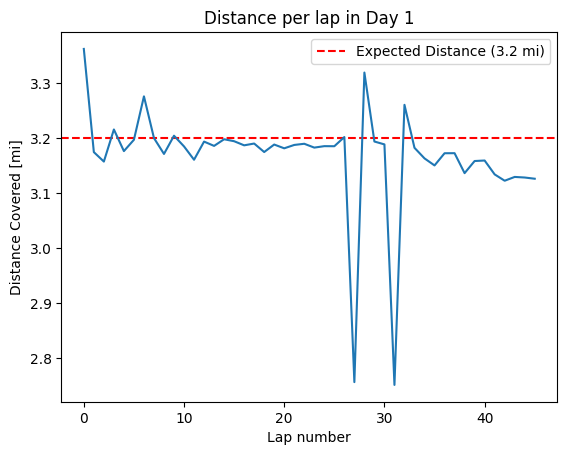

In [15]:
distances = []
for i in range(day.get_lap_count()):
    test_lap = i + 1
    start = day.get_start_utc(test_lap)
    stop = day.get_finish_utc(test_lap)
    start_time = datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
    end_time = datetime.strptime(stop, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
    # vehicle_velocity: TimeSeries = client.query("VehicleVelocity", start_time, end_time)
    vehicle_velocity: TimeSeries = client.query_time_series(start_time, end_time, "VehicleVelocity", granularity = 1,  units="m/s")
    distance = distance_covered(vehicle_velocity, save = True)
    distances.append(distance)

laps = np.array(range(day.get_lap_count()))


plt.title("Distance per lap in Day 1")
plt.xlabel("Lap number")
plt.ylabel("Distance Covered [mi]")
plt.axhline(y=3.20, color='r', linestyle='--', label='Expected Distance (3.2 mi)')
plt.legend()
plt.plot(laps, distances)



#### Finding Avg Distance Covered in DAY 1 Laps 3 - 20

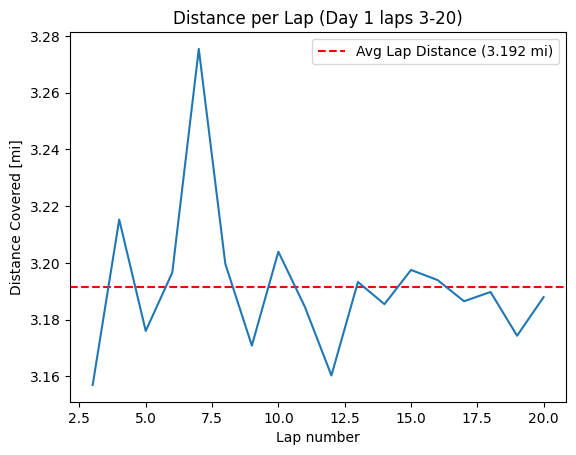

In [16]:
distances = []
for i in range(3, 21):
    test_lap = i
    start = day.get_start_utc(test_lap)
    stop = day.get_finish_utc(test_lap)
    start_time = datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
    end_time = datetime.strptime(stop, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
    vehicle_velocity: TimeSeries = client.query_time_series(start_time, end_time, "VehicleVelocity", granularity = 1,  units="m/s")
    distance = distance_covered(vehicle_velocity, save = True)
    distances.append(distance)

laps = np.array(range(3,21))

avg_lap_distance = np.sum(distances)/(len(laps))

plt.title("Distance per Lap (Day 1 laps 3-20)")
plt.xlabel("Lap number")
plt.ylabel("Distance Covered [mi]")
plt.axhline(y=avg_lap_distance, color='r', linestyle='--', label=f'Avg Lap Distance ({avg_lap_distance:.3f} mi)')
plt.legend()
plt.plot(laps, distances)




#### DAY 3 (DAY 2 has only 3 laps)

In [17]:
#day_num = 3

#day = FSGPDayLaps(day_num)

#### Notes - Pit Stops

- I have figured out when the start of the lap and the end gets measured
- There are some other considerations that need to happen with respect to pit time and such
- Figured out that the pit time does not get accounted for in our distance

## Step 2 - Location of Checkpoints

- Start line coordinates: 37.001055586944915 (N), -86.3685967797545 (W)
- Lap 1 Start coordinates: 

**Use physics model to find map from positon relative to track to coordinates**

**Use percent of lap completed in order to make it more consistent with the physcis tool**

**Use SI Units in Physics thing**

## Step n - Mapping Distance Relative to Track to Coordinates

### Preparation

#### Coordinates

In [18]:
# Importing Coordinates

reverse_coords = [[ 37.00107373, -86.36854755],
    [ 37.0011529 , -86.36837867],
    [ 37.00122817, -86.3682181 ],
    [ 37.00133071, -86.36801267],
    [ 37.00143614, -86.36779264],
    [ 37.00152389, -86.3675912 ],
    [ 37.00160574, -86.36740819],
    [ 37.00167596, -86.36725066],
    [ 37.00175285, -86.36709064],
    [ 37.00183166, -86.36691875],
    [ 37.00192538, -86.36670617],
    [ 37.00200136, -86.36653034],
    [ 37.00208623, -86.36635086],
    [ 37.00215644, -86.36619701],
    [ 37.00222549, -86.36603626],
    [ 37.00229839, -86.3658645 ],
    [ 37.00237732, -86.36569622],
    [ 37.00245038, -86.36553914],
    [ 37.00252912, -86.36537128],
    [ 37.00259904, -86.36521818],
    [ 37.00266755, -86.36507091],
    [ 37.00274639, -86.36490341],
    [ 37.00283342, -86.36471029],
    [ 37.00291248, -86.36454704],
    [ 37.00298517, -86.36439075],
    [ 37.0030636 , -86.36423803],
    [ 37.00313338, -86.36408574],
    [ 37.00320937, -86.36393701],
    [ 37.00330797, -86.36377724],
    [ 37.00343811, -86.36368662],
    [ 37.00357758, -86.36365019],
    [ 37.00372489, -86.36360692],
    [ 37.00388711, -86.36356354],
    [ 37.00405472, -86.36352621],
    [ 37.00423763, -86.36348621],
    [ 37.00437129, -86.36338074],
    [ 37.00448184, -86.36323899],
    [ 37.00457515, -86.36307953],
    [ 37.0047012 , -86.36286956],
    [ 37.00486024, -86.36273924],
    [ 37.00505061, -86.36270756],
    [ 37.00527945, -86.36272947],
    [ 37.00548802, -86.36263566],
    [ 37.00565341, -86.36245496],
    [ 37.00573513, -86.3621647 ],
    [ 37.00568611, -86.36182869],
    [ 37.00548782, -86.36157939],
    [ 37.0052881 , -86.36149696],
    [ 37.00511652, -86.36149669],
    [ 37.0049746 , -86.36158761],
    [ 37.00485989, -86.3616726 ],
    [ 37.00469955, -86.3617696 ],
    [ 37.00451492, -86.36178471],
    [ 37.00435852, -86.36173599],
    [ 37.00419576, -86.36162316],
    [ 37.00409127, -86.36146652],
    [ 37.00404463, -86.3612301 ],
    [ 37.00407232, -86.36097832],
    [ 37.00415922, -86.36078578],
    [ 37.00426711, -86.36066944],
    [ 37.00439509, -86.36060407],
    [ 37.00452844, -86.36057503],
    [ 37.00466778, -86.36054604],
    [ 37.004833  , -86.36050987],
    [ 37.00499495, -86.36047743],
    [ 37.00514229, -86.36044484],
    [ 37.00524902, -86.36041601],
    [ 37.00541074, -86.36037856],
    [ 37.00558676, -86.36034575],
    [ 37.00578957, -86.36038183],
    [ 37.00596102, -86.36045445],
    [ 37.00607154, -86.36065091],
    [ 37.0061651 , -86.36090615],
    [ 37.00626234, -86.3611639 ],
    [ 37.00637312, -86.36147776],
    [ 37.00642557, -86.36179897],
    [ 37.00644459, -86.36216748],
    [ 37.00637929, -86.36250433],
    [ 37.00629836, -86.36273906],
    [ 37.00622229, -86.36291634],
    [ 37.00611158, -86.36309997],
    [ 37.00600738, -86.36323379],
    [ 37.00589169, -86.3633461 ],
    [ 37.00576471, -86.36344689],
    [ 37.00564905, -86.36353398],
    [ 37.00551878, -86.36359932],
    [ 37.00537978, -86.36365448],
    [ 37.00525188, -86.36370605],
    [ 37.0051236 , -86.36376501],
    [ 37.00497727, -86.36382802],
    [ 37.00484855, -86.36391978],
    [ 37.00471266, -86.36403361],
    [ 37.0045783 , -86.36422396],
    [ 37.00447907, -86.36439954],
    [ 37.00435695, -86.36453807],
    [ 37.00424813, -86.36465022],
    [ 37.00411061, -86.36480228],
    [ 37.00397977, -86.36492984],
    [ 37.0038682 , -86.36504946],
    [ 37.00376295, -86.36516126],
    [ 37.00365436, -86.36527329],
    [ 37.00354759, -86.36539144],
    [ 37.00341675, -86.36552332],
    [ 37.00329206, -86.3656715 ],
    [ 37.00316095, -86.36581567],
    [ 37.00303256, -86.36594441],
    [ 37.00291203, -86.36607157],
    [ 37.00278014, -86.36622802],
    [ 37.00269333, -86.36641303],
    [ 37.00260606, -86.36659437],
    [ 37.00252845, -86.36675984],
    [ 37.00243487, -86.36695271],
    [ 37.00234795, -86.36716654],
    [ 37.00226102, -86.36735999],
    [ 37.00218046, -86.36754144],
    [ 37.00210026, -86.36771854],
    [ 37.00202358, -86.36787901],
    [ 37.00194406, -86.36806693],
    [ 37.00185835, -86.36825428],
    [ 37.00177578, -86.36843604],
    [ 37.00169902, -86.36860048],
    [ 37.0016732 , -86.3687928 ],
    [ 37.001679  , -86.3689974 ],
    [ 37.00168488, -86.36919051],
    [ 37.00169122, -86.36938766],
    [ 37.00169469, -86.3695562 ],
    [ 37.00170118, -86.36974238],
    [ 37.00171055, -86.36993991],
    [ 37.00167198, -86.37010864],
    [ 37.00158558, -86.37021273],
    [ 37.00148934, -86.37030898],
    [ 37.00139295, -86.37041757],
    [ 37.00129011, -86.37051816],
    [ 37.00120286, -86.37061913],
    [ 37.00112253, -86.37073184],
    [ 37.00106144, -86.37085264],
    [ 37.00099678, -86.37100197],
    [ 37.00092255, -86.37116696],
    [ 37.00083249, -86.37137665],
    [ 37.00073506, -86.37159438],
    [ 37.00065426, -86.37177611],
    [ 37.00057398, -86.37196168],
    [ 37.00060097, -86.37214635],
    [ 37.00074272, -86.37221467],
    [ 37.0009059 , -86.37222018],
    [ 37.00107657, -86.37218846],
    [ 37.00122503, -86.37211976],
    [ 37.00133803, -86.37204677],
    [ 37.00145467, -86.37192099],
    [ 37.00156457, -86.37178347],
    [ 37.00167114, -86.37162599],
    [ 37.00176434, -86.37145299],
    [ 37.00183833, -86.37126821],
    [ 37.00188646, -86.37112396],
    [ 37.0019441 , -86.37095574],
    [ 37.00197296, -86.370787  ],
    [ 37.00202945, -86.37067751],
    [ 37.00209668, -86.37048098],
    [ 37.00218305, -86.37031655],
    [ 37.00228558, -86.37016005],
    [ 37.00238818, -86.37002764],
    [ 37.00249377, -86.36991909],
    [ 37.00259639, -86.36983868],
    [ 37.00270864, -86.36976266],
    [ 37.00281411, -86.3697033 ],
    [ 37.00292264, -86.36964769],
    [ 37.00303847, -86.369599  ],
    [ 37.00316942, -86.36952703],
    [ 37.00332578, -86.36939126],
    [ 37.00342743, -86.36921198],
    [ 37.00346211, -86.36901195],
    [ 37.00343231, -86.36879509],
    [ 37.00336736, -86.36861758],
    [ 37.00327983, -86.36847602],
    [ 37.00316589, -86.36828932],
    [ 37.00305696, -86.36810259],
    [ 37.00296937, -86.36793662],
    [ 37.00293802, -86.36773416],
    [ 37.00295792, -86.36753614],
    [ 37.00301643, -86.36739089],
    [ 37.00307192, -86.36724611],
    [ 37.00312788, -86.36711056],
    [ 37.00320856, -86.36698638],
    [ 37.00331523, -86.36684361],
    [ 37.00340519, -86.36672019],
    [ 37.00350264, -86.36658791],
    [ 37.00361135, -86.36649982],
    [ 37.00374245, -86.36645177],
    [ 37.00387034, -86.3664758 ],
    [ 37.00395668, -86.36655587],
    [ 37.00402368, -86.36670753],
    [ 37.00407807, -86.36686779],
    [ 37.00412607, -86.36701603],
    [ 37.00418686, -86.36718831],
    [ 37.00427315, -86.36742386],
    [ 37.00436296, -86.3676927 ],
    [ 37.00442144, -86.36790543],
    [ 37.00445858, -86.36815496],
    [ 37.00447715, -86.36847342],
    [ 37.00444541, -86.36882644],
    [ 37.00434238, -86.36911386],
    [ 37.00425654, -86.36927291],
    [ 37.00418289, -86.36939303],
    [ 37.00410293, -86.36950912],
    [ 37.00399731, -86.36962489],
    [ 37.00390147, -86.36973254],
    [ 37.00379293, -86.36984054],
    [ 37.00369701, -86.36994104],
    [ 37.00359474, -86.37004514],
    [ 37.0034838 , -86.3701598 ],
    [ 37.00338477, -86.37024376],
    [ 37.00327609, -86.37032788],
    [ 37.00318982, -86.37040789],
    [ 37.00306205, -86.37049992],
    [ 37.00294389, -86.37059192],
    [ 37.00283177, -86.37070006],
    [ 37.00272312, -86.37083897],
    [ 37.00264003, -86.37094293],
    [ 37.00255683, -86.37103895],
    [ 37.00249914, -86.37115127],
    [ 37.00243497, -86.37126771],
    [ 37.00236746, -86.3713964 ],
    [ 37.00230001, -86.37152106],
    [ 37.00223561, -86.37164596],
    [ 37.00217132, -86.37175865],
    [ 37.0021135 , -86.37187932],
    [ 37.00204601, -86.37200003],
    [ 37.00196791, -86.37211434],
    [ 37.00188761, -86.3722312 ],
    [ 37.00180726, -86.37233202],
    [ 37.00173651, -86.37241676],
    [ 37.00165284, -86.37250555],
    [ 37.00155067, -86.3726109 ],
    [ 37.00144762, -86.37271211],
    [ 37.00136704, -86.37279282],
    [ 37.00126713, -86.37288565],
    [ 37.00115123, -86.37299929],
    [ 37.00103518, -86.37310829],
    [ 37.0009191 , -86.37321738],
    [ 37.00082561, -86.37329809],
    [ 37.00072863, -86.37339546],
    [ 37.00061364, -86.37350099],
    [ 37.00051698, -86.37360214],
    [ 37.00042667, -86.37368311],
    [ 37.00032338, -86.37378434],
    [ 37.00022342, -86.37387665],
    [ 37.00012018, -86.3739737 ],
    [ 37.00002051, -86.37405916],
    [ 36.99991404, -86.37415222],
    [ 36.99981076, -86.37423248],
    [ 36.99970432, -86.37430523],
    [ 36.99958169, -86.37432571],
    [ 36.99946928, -86.37430399],
    [ 36.99934964, -86.37428072],
    [ 36.99922365, -86.37425686],
    [ 36.99908793, -86.37422888],
    [ 36.99899069, -86.37413638],
    [ 36.99896465, -86.37397888],
    [ 36.9989808 , -86.37380904],
    [ 36.99900664, -86.37362303],
    [ 36.99904589, -86.37342887],
    [ 36.9990885 , -86.37323096],
    [ 36.99912743, -86.3730292 ],
    [ 36.99916641, -86.37284378],
    [ 36.99921127, -86.37261758],
    [ 36.99924349, -86.37245211],
    [ 36.99932082, -86.37230251],
    [ 36.99932082, -86.37230251],
    [ 36.99940337, -86.37214797],
    [ 36.99948814, -86.37199725],
    [ 36.99958754, -86.37189043],
    [ 36.99970528, -86.37178738],
    [ 36.99982625, -86.37169183],
    [ 36.99997073, -86.37159181],
    [ 37.00011471, -86.3714889 ],
    [ 37.00027357, -86.37138907],
    [ 37.0003852 , -86.37123775],
    [ 37.00042033, -86.37099884],
    [ 37.00038811, -86.3707825 ],
    [ 37.00031195, -86.37062837],
    [ 37.00026491, -86.37041498],
    [ 37.00030254, -86.37020247],
    [ 37.00038472, -86.3700261 ],
    [ 37.0004699 , -86.36984594],
    [ 37.00056383, -86.36964375],
    [ 37.00064015, -86.3694857 ],
    [ 37.00070993, -86.36934481],
    [ 37.0008098 , -86.36912411],
    [ 37.00090662, -86.36891836],
    [ 37.00098578, -86.36874579],
    [ 37.00107373, -86.36854755]
  ]

coords = reverse_coords[::-1]

#### GIS Object

In [19]:
from physics.environment.gis.gis import GIS
from physics.environment.gis.gis import calculate_path_distances

# Defining dictionary "route_data"

route_data = {
    "path" : coords,
    "elevations" : np.zeros(len(coords)),
    "time_zones" : np.zeros(len(coords)),
    "num_unique_coords" : (len(coords) - 1) }

# Creating GIS object

starting_coords = [37.00107373, -86.36854755]

gis = GIS(route_data, starting_coords, current_coord = starting_coords)

lap_length = np.cumsum(calculate_path_distances(gis.path[:gis.num_unique_coords]))[-1] # TOTAL LAP LENGTH

#### Testing for Lap 7:

I am taking lap 7. We know its start time, and we will set an arbitrary end time for the query that is not the end time to the lap. Essentially, we are in the middle of the lap and we want to find the car's location. First we can calculate the distance covered at that point. Then we can map that distance covered to a coordinate.

In [20]:
# Test lap information

print(f"The total length of the track is {lap_length}")

lap = 7
start = "2024-07-16T15:40:21Z"
#end = "2024-07-16T15:43:45Z" # LAP END TIME: 2024-07-16T15:47:45Z

end = "2024-07-16T15:47:45Z"

so_far = distance_so_far(start, end, save = True)

The total length of the track is 5033.62413471853


TypeError: distance_so_far() got an unexpected keyword argument 'save'

In [ ]:
gis._python_calculate_closest_gis_indices(np.array([0]), gis.get_path_distances())

#print(route_data.get("path")[1])

In [ ]:
x =route_data.get("path")[0]
print(x)

#### Further Testing and Validation for Distance-to-Coordinates Mapping (Lap 14)

In [ ]:
# Getting lap and day

day_num = 1
day = FSGPDayLaps(day_num)
lap = 14

##### Checking Start Position Works as Intended

If the car has not moved at all, its coordinates should be the start coordinates. We can't give the same time stamp, so we just pick a timestamp that is a second after the start time. The distance covered should be minimal, therefore, the difference between the start coordinate and the new coordinate should be small.

In [ ]:
# Time stamps to check
start = day.get_start_utc(lap) # start time stamp
end = "2024-07-16T16:28:33Z" # two seconds after start

expected = [37.00107373, -86.36854755] # starting coordinates

distance = distance_so_far(start, end, save = True)[0]

print(f"The distance covered is {distance} m ")

result = return_coords(start, end, lap)

print(f"Our estimated coordinates are {result}")

difference = calculate_path_distances(np.array([expected, result])) # one distance returned

print(f"The difference between expected and calculated coordinates is {difference[0]} m")

##### Checking Final Position Works as Intended

If the car has completed a full lap, its coordinates should go back to the start coordinates.

In [ ]:
# Time stamps to check
start = day.get_start_utc(lap) # start time stamp
end = day.get_finish_utc(lap) # end of lap

expected = [37.00107373, -86.36854755] # we expect to go back to the starting coordinates after one lap

distance = distance_so_far(start, end, save = True)[0]

print(distance)

result = return_coords(start, end, lap)

print(f"End coords were calculated to be {result}")

difference = calculate_path_distances(np.array([expected, result])) # one distance returned

print(difference)

In [ ]:
gis._find_closest_coordinate_index(np.array([37.00107373, -86.36854755]), route_data.get("path"))

##### Checking A Coordinate in the Middle

Over here, I am just checking that if I use some point in the middle of the lap, the coordinate I get makes sense.

In [ ]:
# Time stamps to check
start = day.get_start_utc(lap) # start time stamp
end = "2024-07-16T16:30:59Z" # end time stamp, the lap actually ends at 2024-07-16T15:33:59Z

distance = distance_so_far(start, end, save = True)[0]

print(f"The distance that was covered is {distance} m")

result = return_coords(start, end, lap)

print(f"End coords should be {result}")

difference = calculate_path_distances(np.array([expected, route_data.get("path")[0]])) # one distance returned

print(difference)

I checked this coordinate with the one given by Google Maps measure tools, and it matched up. Seems like it makes sense.

##### Testing Entire Lap - Velocity vs Index

Making sure that the coordinates for an entire lap makes sense. Should match up somewhat with velocity graph. Plot velocity as a function of time and index as a function of time. We should see that the rate of change of index is higher when the rate of change of position (velocity) is higher.

In [ ]:
from datetime import datetime, timedelta

start = day.get_start_utc(14) # 2024-07-16T16:28:31Z
end = day.get_finish_utc(14) # 2024-07-16T16:36:25Z
start_time = datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
end_time = datetime.strptime(stop, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)

velocity = client.query_time_series(start_time, end_time, "VehicleVelocity", granularity = 1,  units="m/s")
times = range(len(velocity))

indices = []
for i in range(len(velocity)):
    #start = "2024-07-16T16:28:31Z"
    #end = f"2024-07-16T16:28:{32+i}Z"
    start = datetime.strptime("2024-07-16T16:28:31Z", "%Y-%m-%dT%H:%M:%SZ")
    start_str = "2024-07-16T16:28:31Z"
    end = start + timedelta(seconds=i+1)  # i+1 to match your second increment logic
    
    # Convert the `end` time back to the string format if needed for your functions
    end_str = end.strftime("%Y-%m-%dT%H:%M:%SZ")
    distance = distance_so_far(start_str, end_str, save = True)[0]
    total_lap_distance = distance_covered_lap(14, save = True)
    total_track_length = 5033.62413471853
    index = gis._python_calculate_closest_gis_indices(np.array([(distance / total_lap_distance) * total_track_length]), gis.get_path_distances())
    indices.append(index[0])

np.save('indices_array.npy', indices)

    
    
    

###### Getting indices for Lap 14

In [ ]:
"""from datetime import datetime, timedelta

start = day.get_start_utc(14) # 2024-07-16T16:28:31Z
end = day.get_finish_utc(14) # 2024-07-16T16:36:25Z
start_time = datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
end_time = datetime.strptime(stop, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)

velocity = client.query_time_series(start_time, end_time, "VehicleVelocity", granularity = 1,  units="m/s")
times = range(len(velocity))

start = datetime.strptime("2024-07-16T16:28:31Z", "%Y-%m-%dT%H:%M:%SZ")
indices = []
distances = np.zeros(len(velocity))
for i in range(len(velocity)):
    #start = "2024-07-16T16:28:31Z"
    #end = f"2024-07-16T16:28:{32+i}Z"
    start_str = f"2024-07-16T16:28:3{1+i}Z"
    end = start + timedelta(seconds=i+1)  # i+1 to match your second increment logic
    
    # Convert the `end` time back to the string format if needed for your functions
    end_str = end.strftime("%Y-%m-%dT%H:%M:%SZ")
    distance = distance_so_far(start_str, end_str, save = True)[0]
    total_lap_distance = distance_covered_lap(14, save = True)
    total_track_length = 5033.62413471853
    distances[i] = (distance / total_lap_distance) * total_track_length"""
    


#np.save('indices_array.npy', indices)


###### Comparing Velocity/Time and PathIndex/Time

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
x = times  # Common x-axis
y1 = velocity
y2 = indices

# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot the first dataset on the primary y-axis
ax1.plot(x, y1, color='b', label='Velocity')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Velocity (m/s)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis
ax2 = ax1.twinx()  # This creates a new axes that shares the same x-axis

# Plot the second dataset on the secondary y-axis
ax2.plot(x, y2, color='r', label='Index', linestyle='--')
ax2.set_ylabel('Path Index', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Optional: Add legends for clarity
fig.tight_layout()  # To ensure the layout is neat
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Title and show the plot
plt.title('Velocity/Time and PathIndex/Time for Lap 14')
plt.grid()
plt.show()

###### Derivative of Indices

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

loaded_indices = np.load('indices_array.npy')

# Compute the derivative (rate of change of indices with respect to time)
derivative = np.diff(indices) / np.diff(times)

# Create a time array for the derivative (midpoints)
time_derivative = [(times[i] + times[i + 1]) / 2 for i in range(len(times) - 1)]

plt.plot(time_derivative, derivative, marker='o', linestyle='-', color='r', label='Derivative')
plt.xlabel('Time')
plt.ylabel('Derivative (Rate of Change)')
plt.title('Derivative of Indices vs. Time')
plt.legend()
plt.grid()

# Adjust layout and show the plot
plt.xlim(0, 100)  # Replace with your desired time range
#plt.ylim(start_derivative, end_derivative)  # Replace with your desired derivative range

plt.tight_layout()
plt.show()


###### Velocity/Time vs Derivative-Index/Time

In [ ]:
x = time_derivative  # Common x-axis
y1 = velocity[0:439]
y2 = derivative

# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot the first dataset on the primary y-axis
ax1.plot(x, y1, color='b', label='Velocity')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Velocity (m/s)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis
ax2 = ax1.twinx()  # This creates a new axes that shares the same x-axis

# Plot the second dataset on the secondary y-axis
ax2.plot(x, y2, color='r', label='Derivative of Index', linestyle='--')
ax2.set_ylabel('Derivative of Path Index', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Optional: Add legends for clarity
fig.tight_layout()  # To ensure the layout is neat
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Title and show the plot
plt.title('Velocity/Time and DerivativePathIndex/Time for Lap 14')
plt.grid()
plt.show()

##### Testing Entire Lap - Distance vs Index

Comparing our velocity data with the index proved to not be very effective because it is harder to see that the plots make sense. Fortunately, Jonah had the idea of instead comparing distance covered vs index because after all we do treat index like a distance metric. The results are outlined below.

In [ ]:
# indices = np.load('indices_array.npy')
# calculating distances

distances = []
for i in range(len(velocity)):
    #start = "2024-07-16T16:28:31Z"
    #end = f"2024-07-16T16:28:{32+i}Z"
    start = datetime.strptime("2024-07-16T16:28:31Z", "%Y-%m-%dT%H:%M:%SZ")
    start_str = "2024-07-16T16:28:31Z"
    end = start + timedelta(seconds=i+1)  # i+1 to match your second increment logic
    
    # Convert the `end` time back to the string format if needed for your functions
    end_str = end.strftime("%Y-%m-%dT%H:%M:%SZ")
    distance = distance_so_far(start_str, end_str, save = True)[0]
    distances.append(distance)

###### Plotting

In [ ]:
x = times  # Common x-axis
y1 = distances
y2 = indices

# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot the first dataset on the primary y-axis
ax1.plot(x, y1, color='b', label='Distance')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Distance (m)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis
ax2 = ax1.twinx()  # This creates a new axes that shares the same x-axis

# Plot the second dataset on the secondary y-axis
ax2.plot(x, y2, color='r', label='Index', linestyle='--')
ax2.set_ylabel('Path Index', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Optional: Add legends for clarity
fig.tight_layout()  # To ensure the layout is neat
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Title and show the plot
plt.title('Distance/Time and PathIndex/Time for Lap 14')
plt.grid()
plt.show()

#### Accounting for Lap 1 Difference

Lap 1 is a little bit longer because the car started from further behind. There is a difference of distance covered that needs to be accounted for.

In [ ]:
# Lap 1 Difference

"""d = distance_covered_lap(1, save = True)

print(d -  5149.9)"""

### Velocity between Each Pair of Coordinates - Lap 14

I am attempting to plot every coordinate of the track in a grid. I then want to have a color map to velocity. Essentially, we want to show where in the track we were faster.

In [ ]:
from matplotlib.collections import LineCollection
from matplotlib import cm

day_num = 1
day = FSGPDayLaps(day_num)
lap = 14
start = day.get_start_utc(lap)
stop = day.get_finish_utc(lap)
start_time = datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
end_time = datetime.strptime(stop, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
velocities: TimeSeries = client.query_time_series(start_time, end_time, "VehicleVelocity", granularity = 1,  units="m/s")

x_coords = [coord[1] for coord in coords]
y_coords = [coord[0] for coord in coords]

points = np.array([x_coords, y_coords]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Normalize the velocity values to map them to a color map
norm = plt.Normalize(min(velocities), max(velocities))
lc = LineCollection(segments, cmap='gnuplot', norm=norm, linewidth =3)

# Set the color of each segment based on velocity
lc.set_array(np.array(velocities))

# Create plot
plt.figure(figsize=(8, 6))
plt.gca().add_collection(lc)
plt.plot(x_coords, y_coords, linestyle='None')  # Plot points without connecting them

# Add a color bar to show the velocity scale
plt.colorbar(lc, label='Velocity (m/s)')

# Add labels, grid, and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f'Velocity on the Track Day {day_num} Lap {lap}')
plt.grid(True)

# Adjust the axis limits to fit the track
plt.xlim(min(x_coords) - 0.0002, max(x_coords) + 0.0002)
plt.ylim(min(y_coords) - 0.0002, max(y_coords) + 0.0002)

plt.scatter(x_coords[0], y_coords[0], color='red', s=200, marker='*', label='Start Point')

# Optionally, you can add a label to the start point
plt.legend()

# Display the plot
plt.show()

#### Second Attempt

Before, the velocities were normalized. Here I am attempting the method of mapping the exact coordinate to the exact velocity.

In [ ]:
start = day.get_start_utc(14)
stop = day.get_finish_utc(14)
start_time = datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
end_time = datetime.strptime(stop, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
velocities: TimeSeries = client.query_time_series(start_time, end_time, "VehicleVelocity", granularity = 1,  units="m/s")

indices = np.load('indices_array.npy')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# Assume x_coords and y_coords are the coordinates, and velocities is the list of velocities
# For example:

coordinates = []
for i in indices:
    coordinates.append(coords[i])


x_coords = [coord[1] for coord in coordinates]
y_coords = [coord[0] for coord in coordinates]

# Create an array of points from the coordinates
points = np.array([x_coords, y_coords]).T.reshape(-1, 1, 2)

# Create segments by connecting the points
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Normalize the velocity values for the color map
norm = plt.Normalize(min(velocities), max(velocities))

# Create a LineCollection, where each segment is colored based on the velocity
lc = LineCollection(segments, cmap='gnuplot', norm=norm, linewidth=3)

# Set the color of each segment based on the velocity values
lc.set_array(np.array(velocities))

# Create a plot
plt.figure(figsize=(8, 6))
plt.gca().add_collection(lc)
plt.plot(x_coords, y_coords, linestyle='None')  # Plot points without connecting them

# Add a color bar to show the velocity scale
plt.colorbar(lc, label='Velocity (m/s)')

# Add labels, grid, and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Velocities in Lap 14')
plt.grid(True)


# Adjust the axis limits to fit the track
plt.xlim(min(x_coords) - 0.0002, max(x_coords) + 0.0002)
plt.ylim(min(y_coords) - 0.0002, max(y_coords) + 0.0002)

# Optionally, highlight the starting point
plt.scatter(x_coords[0], y_coords[0], color='red', s=200, marker='*', label='Start Point')

# Add a legend and show the plot
plt.legend()
plt.show()


In [ ]:
"""import numpy as np
from datetime import datetime, timedelta

# Assume velocity is your input array
start = day.get_start_utc(lap)
stop = day.get_finish_utc(lap)
start_time = datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
end_time = datetime.strptime(stop, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
velocity = client.query_time_series(start_time, end_time, "VehicleVelocity", granularity = 1,  units="m/s")
num_points = len(velocity)
distances = np.zeros(num_points)  # Preallocate array

start = datetime.strptime("2024-07-16T16:28:31Z", "%Y-%m-%dT%H:%M:%SZ")
total_track_length = 5033.62413471853
total_lap_distance = distance_covered_lap(14, save=True)  # Calculate this once

for i in range(num_points):
    end = start + timedelta(seconds=i + 1)
    # Convert the `end` time back to the string format if needed for your functions
    end_str = end.strftime("%Y-%m-%dT%H:%M:%SZ")
    distance = distance_so_far(start.strftime("%Y-%m-%dT%H:%M:%SZ"), end_str, save=True)[0]
    
    # Calculate the distance ratio and store it directly in the array
    result = (distance / total_lap_distance) * total_track_length
    if result >= total_track_length:
        distances[i] = 5033.62413471
    else:
        distances[i] = result
"""

### Velocity between Each Pair of Coordinates - Average Across Laps Day 1 

I want to repeat the same process as before, except take the average for all laps. I will however, omit 3 laps: the first one because we had a different starting position, as well as the 28th and the 32nd because we pitted and the car did a lot of driving in other parts of the track.

In [ ]:
from scipy.interpolate import interp1d
import numpy as np

# Use the coordinates from the first lap as the reference
reference_x_coords = x_coords  # These are the actual x coordinates from the first lap
reference_y_coords = y_coords  # These are the actual y coordinates from the first lap
num_points = len(reference_x_coords)

# Initialize an array to store the interpolated velocities for each lap
interpolated_velocities = np.zeros((num_laps, num_points))

for lap in range(1, num_laps + 1):
    # omit laps 1, 28, 32
    if (i+1) == 1 or (i+1) ==28 or (i+1) ==32:
        continue
    else:
        start = day.get_start_utc(lap)
        stop = day.get_finish_utc(lap)
        start_time = datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
        end_time = datetime.strptime(stop, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
        velocities: TimeSeries = client.query_time_series(start_time, end_time, "VehicleVelocity", granularity=1, units="m/s")
        interp_func = interp1d(np.linspace(0, 1, len(velocities)), velocities, kind='linear', fill_value="extrapolate")
        interpolated_velocities[lap - 1, :] = interp_func(np.linspace(0, 1, num_points))

# Calculate the average velocity at each reference point
average_velocities = np.mean(interpolated_velocities, axis=0)

# Create the plot with average velocities
points = np.array([reference_x_coords, reference_y_coords]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Normalize the average velocity values to map them to a color map
norm = plt.Normalize(min(average_velocities), max(average_velocities))
lc = LineCollection(segments, cmap='gnuplot', norm=norm, linewidth=3)

# Set the color of each segment based on average velocity
lc.set_array(np.array(average_velocities))

# Create plot
plt.figure(figsize=(8, 6))
plt.gca().add_collection(lc)
plt.plot(reference_x_coords, reference_y_coords, linestyle='None')  # Plot points without connecting them

# Add a color bar to show the average velocity scale
plt.colorbar(lc, label='Average Velocity (m/s)')

# Add labels, grid, and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Average Velocity on the Track Over All Laps')
plt.grid(True)

# Adjust the axis limits to fit the track
plt.xlim(min(reference_x_coords) - 0.0002, max(reference_x_coords) + 0.0002)
plt.ylim(min(reference_y_coords) - 0.0002, max(reference_y_coords) + 0.0002)

plt.scatter(reference_x_coords[0], reference_y_coords[0], color='red', s=200, marker='*', label='Start Point')

# Optionally, you can add a label to the start point
plt.legend()

# Display the plot
plt.show()


In [ ]:
# Finding average velocities

velocities_all = []
for i in range(day.get_lap_count()):
    if (i+1) == 1 or (i+1) ==28 or (i+1) ==32:
        continue
    else:
        start = day.get_start_utc(i+1)
        stop = day.get_finish_utc(i+1)
        start_time = datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
        end_time = datetime.strptime(stop, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
        velocities: TimeSeries = client.query_time_series(start_time, end_time, "VehicleVelocity", granularity = 1,  units="m/s")
        velocities_all.append(velocities)



### General Solution

The rationale here is that I am given a time stamp, and I want to identify what lap that timestamp is in. I will then be able to find the distance covered so far.

#### Data Given

In [ ]:
day_num = 1

day = FSGPDayLaps(day_num)

lap = 5

start = day.get_start_utc(test_lap)
stop = day.get_finish_utc(test_lap)
start_time = datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
end_time = datetime.strptime(stop, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)

#### Finding Lap From Time Stamp

In [ ]:
import pandas as pd

# Replace 'your_file.csv' with the path to your CSV file
df = pd.read_csv('venv/Lib/site-packages/data_tools/static_data/fsgp_timing_2024/fsgp_timing_day_1.csv')

# Display the first few rows of the CSV to understand its structure
df.head()

In [ ]:
pd.options.display.max_rows = 9999

df

In [ ]:
day_num = 1

day = FSGPDayLaps(day_num)

print(day.get_lap_count())

day.get_start_utc(1)

#### Start of Mapping

In [ ]:
# This assumes start and stop time stamps are in the same lap

def return_coords(start: str, stop: str, lap: int):
    distance = distance_so_far(start, stop, save = True)[0]
    total_lap_distance = distance_covered_lap(lap, save = True)
    total_track_length = 5033.62413471853
    index = gis._python_calculate_closest_gis_indices(np.array([(distance / total_lap_distance) * total_track_length]), gis.get_path_distances())
    return route_data.get("path")[index[0]]

# !!! Missing Find Lap Function
    

In [ ]:
return_coords("2024-07-16T15:40:21Z", "2024-07-16T15:43:45Z", 7)